In [1]:
# Tools
#loading Arxiv
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper

In [2]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv,description="query arxiv papers")
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("attention all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [4]:
api_wraper_wikipedia=WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wraper_wikipedia, description="wikipedia search")
wiki.name

'wikipedia'

In [5]:
wiki.invoke("Sachin Tendulkar")

'Page: Sachin Tendulkar\nSummary: Sachin Ramesh Tendulkar ( ; Marathi: [sətɕin t̪eɳɖulkəɾ]; born 24 April 1973) is an Indian former international cricketer who captained the Indian national team. Often dubbed the "God of Cricket" in India, he is widely regarded as one of the greatest cricketers of all time. He holds several world records, including being the all-time highest run-scorer in international cricket, receiving the most player of the match awards in international cricket, and being the o'

In [6]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")


In [7]:
from langchain_community.tools.tavily_search import TavilySearchResults


In [8]:
tavily=TavilySearchResults()

C:\Users\parth\AppData\Local\Temp\ipykernel_7804\1844490623.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily=TavilySearchResults()


In [9]:
tavily.invoke("Provide me recent AI news")

[{'title': 'The Latest AI News and AI Breakthroughs that Matter Most: 2025',
  'url': 'https://www.crescendo.ai/news/latest-ai-news-and-updates',
  'content': 'Date: December 10, 2025 Summary: Google has expanded its AI lineup with the release of Gemini 3 Flash, a lightweight model optimized for speed and efficiency at scale. Designed for developers requiring low-latency responses, the new model features a massive context window while significantly reducing operational costs. Google claims the Flash variant is ideal for real-time applications like live translation, rapid coding assistance, and high-volume data processing, further intensifying the [...] Date: December 18, 2025 Summary: Following a recent attack in Bondi, a wave of AI-generated misinformation, including altered images and "psyop" conspiracy theories, has flooded social media platforms. The spread of these synthetic materials has complicated the efforts of law enforcement and official news outlets to provide accurate info

In [10]:
tools=[arxiv,wiki,tavily]

In [11]:
from langchain_groq import ChatGroq

In [12]:
llm=ChatGroq(model="qwen/qwen3-32b")

In [13]:
llm.invoke("what is AI")

AIMessage(content='<think>\nOkay, so I need to figure out what AI is. Let me start by recalling what I know. AI stands for Artificial Intelligence. From what I remember, it\'s about making machines or computers perform tasks that usually require human intelligence. But I\'m not exactly sure what those tasks are. Maybe things like problem-solving, learning, understanding language?\n\nWait, there\'s also machine learning, which I think is a subset of AI. Machine learning is when computers learn from data without being explicitly programmed. So, instead of following strict rules, they find patterns in data. That makes sense. But how does that relate to AI? Maybe AI is the broader concept, and machine learning is a part of it.\n\nThen there\'s deep learning, which I\'ve heard about in the context of neural networks. Neural networks are supposed to mimic the human brain\'s structure, right? So deep learning might be a technique used in machine learning to process data in layers. That probab

In [14]:
llm_with_tools=llm.bind_tools(tools=tools)


In [15]:
llm_with_tools.invoke("What is recent news on AI")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent news on AI. Let me see which tool I should use here. The available tools are arxiv, wikipedia, and tavily_search_results_json. \n\nArxiv is for academic papers, so maybe not the best choice for recent news. Wikipedia might have some information, but it\'s more of an encyclopedia and might not have the latest updates. The third option is tavily_search_results_json, which is described as a search engine optimized for current events. That sounds perfect for this query.\n\nSo I should use tavily_search_results_json with the query "recent news on AI". The parameters require a query string, which in this case would be "recent AI news" or similar. Let me make sure the query is phrased correctly. The user wants recent news, so including terms like "latest" or "recent" would help. I\'ll go with "recent AI news" as the search query. \n\nI need to structure the tool call correctly. The function name

In [16]:
llm_with_tools.invoke("What is latest research paper quantum computing")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for the latest research paper on quantum computing. Let me think about how to approach this.\n\nFirst, I need to figure out which tool to use. The available tools are arxiv, wikipedia, and tavily_search_results_json. Arxiv is a repository for preprint papers, so that\'s probably the best place to look for the latest research. Wikipedia might have general information but not the most recent papers. Tavily seems to be a search engine, but if the user wants specific papers, arxiv would be more direct.\n\nSo, I\'ll use the arxiv function. The parameter required is a query. The user\'s query is "latest research paper quantum computing". I should structure the arxiv query to find the most recent papers. Maybe using keywords like "quantum computing" and sorting by date. But the arxiv function\'s parameters just take a query string. I\'ll need to phrase the query appropriately. Perhaps "quantum computing" w

In [17]:
#building workflow in LangGraph
from typing_extensions import TypedDict #for entire State
from langchain_core.messages import AnyMessage #human or AI message
from typing import Annotated  #labeling
from langgraph.graph.message import add_messages #add messages is reducer in langgraph

In [18]:
class State(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]

In [19]:
from IPython.display import display,Image
from langgraph.graph import StateGraph,START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [20]:
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

#graph building
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))


In [21]:
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", END)

In [22]:
#compile graph
graph_builder = builder.compile()

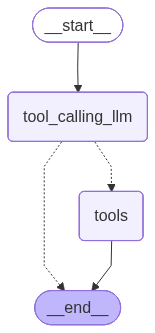

In [23]:
#view graph
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [24]:
from langchain_core.messages import HumanMessage
temp_message = graph_builder.invoke(
    {"messages": [HumanMessage(content="What is pydantic library?")]}
)

In [25]:
for m in temp_message["messages"]:
    print(m.pretty_print())

================================ Human Message =================================

What is pydantic library?
None
================================== Ai Message ==================================

The Pydantic library is a Python tool for data validation and settings management. It enforces type hints at runtime, ensuring that data conforms to specified structures and types. This helps catch errors early and makes code more robust and self-documenting. Pydantic is widely used in frameworks like FastAPI to validate API requests and responses, but it's also applicable to any data processing scenario. Key features include automatic data conversion, comprehensive error messages, and integration with Python's type hinting system. For example, you can define a model using a class with type-annotated fields, and Pydantic will validate and parse data against this model.
None
